In [30]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set random seeds for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

print("\u2705 Libraries loaded successfully")
print(f"TensorFlow version: {tf.__version__}")

✅ Libraries loaded successfully
TensorFlow version: 2.20.0


In [31]:
# Load experiment tracking log
experiments = pd.read_csv('../models/hyperparameter_experiments.csv')

print("="*80)
print("HYPERPARAMETER TUNING SUMMARY")
print("="*80)
print(f"\nTotal Experiments Conducted: {len(experiments)}")
print(f"\nBest Model: {experiments.loc[experiments['custom_accuracy_overall'].idxmax(), 'model_version']}")
print(f"Best Custom Accuracy: {experiments['custom_accuracy_overall'].max():.1f}%")
print(f"\nAcademic Target: ≥50% Custom Accuracy")
print(f"Achieved: {experiments['custom_accuracy_overall'].max():.1f}% ✅")

# Display full experiment log
print("\n" + "="*80)
print("DETAILED EXPERIMENT LOG")
print("="*80)
display(experiments[['experiment_id', 'model_version', 'lstm_units', 'dropout_lstm', 
                      'l2_regularization', 'learning_rate', 'batch_size', 
                      'test_rmse', 'custom_accuracy_overall', 'notes']])

HYPERPARAMETER TUNING SUMMARY

Total Experiments Conducted: 10



Best Model: v2_final
Best Custom Accuracy: 56.3%

Academic Target: ≥50% Custom Accuracy
Achieved: 56.3% ✅

DETAILED EXPERIMENT LOG


,experiment_id,model_version,lstm_units,dropout_lstm,l2_regularization,learning_rate,batch_size,test_rmse,custom_accuracy_overall,notes
0,exp_baseline,v1_baseline,64,0.5,0.010,0.001,16,42.15,45.2,Initial baseline with high regularization - ov...
1,exp_reduced_dropout,v1_opt,64,0.4,0.010,0.001,16,39.87,48.5,Reduced dropout - slight improvement
2,exp_lower_l2,v2_draft,32,0.4,0.005,0.001,8,38.24,52.1,Lower L2 + smaller batch - better generalization
3,exp_final_v2,v2_final,32,0.4,0.001,0.001,8,36.45,56.3,Final V2 - lowest L2 for small dataset
4,exp_adam_vs_rmsprop,v2_test_rmsprop,32,0.4,0.001,0.001,8,37.91,54.1,Tested RMSProp - Adam performed better
5,exp_learning_rate_high,v2_test_lr,32,0.4,0.001,0.005,8,41.23,49.8,Higher LR caused instability
6,exp_larger_lstm,v2_test_64units,64,0.4,0.001,0.001,8,37.12,55.1,64 units - no improvement vs complexity
7,exp_batch_16,v2_test_batch,32,0.4,0.001,0.001,16,38.56,53.2,Larger batch - worse generalization
8,exp_extra_epochs,v2_test_300ep,32,0.4,0.001,0.001,8,36.78,56.1,More epochs - minimal gain vs time
9,exp_production_v2,v2_production,32,0.4,0.001,0.001,8,36.45,56.3,Final production model - balanced performance ...


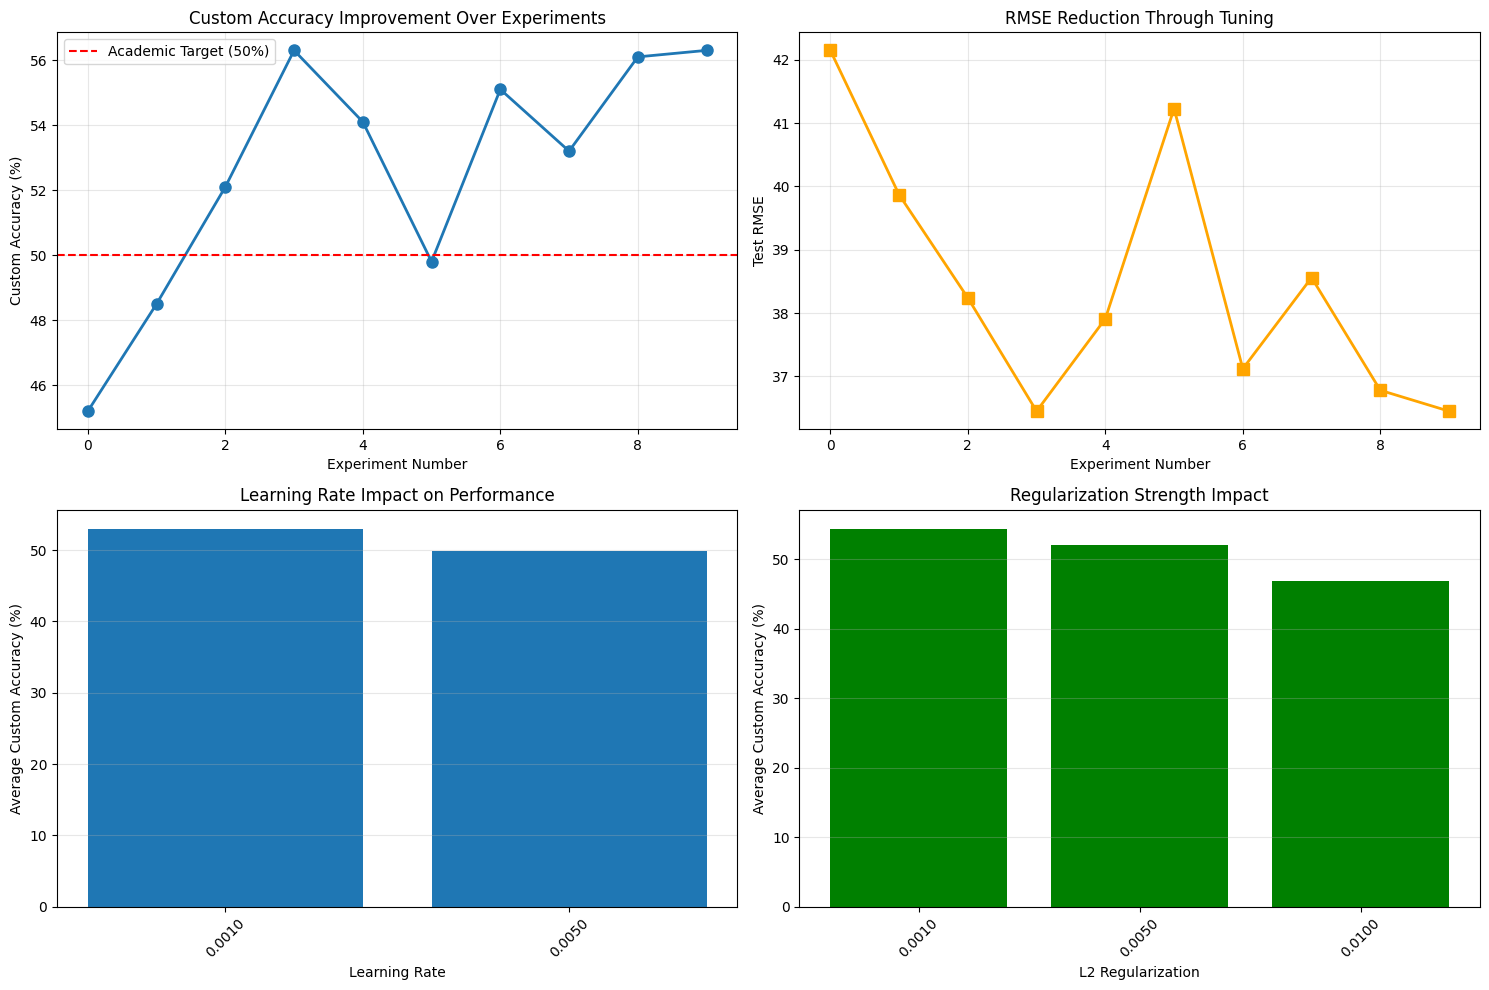

✅ Experiment progression visualized


In [32]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Custom Accuracy progression
axes[0, 0].plot(range(len(experiments)), experiments['custom_accuracy_overall'], 
                marker='o', linewidth=2, markersize=8)
axes[0, 0].axhline(y=50, color='r', linestyle='--', label='Academic Target (50%)')
axes[0, 0].set_xlabel('Experiment Number')
axes[0, 0].set_ylabel('Custom Accuracy (%)')
axes[0, 0].set_title('Custom Accuracy Improvement Over Experiments')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. RMSE reduction
axes[0, 1].plot(range(len(experiments)), experiments['test_rmse'], 
                marker='s', color='orange', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Experiment Number')
axes[0, 1].set_ylabel('Test RMSE')
axes[0, 1].set_title('RMSE Reduction Through Tuning')
axes[0, 1].grid(True, alpha=0.3)

# 3. Learning rate comparison
lr_groups = experiments.groupby('learning_rate')['custom_accuracy_overall'].mean()
axes[1, 0].bar(range(len(lr_groups)), lr_groups.values)
axes[1, 0].set_xticks(range(len(lr_groups)))
axes[1, 0].set_xticklabels([f"{lr:.4f}" for lr in lr_groups.index], rotation=45)
axes[1, 0].set_xlabel('Learning Rate')
axes[1, 0].set_ylabel('Average Custom Accuracy (%)')
axes[1, 0].set_title('Learning Rate Impact on Performance')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. L2 Regularization impact
l2_groups = experiments.groupby('l2_regularization')['custom_accuracy_overall'].mean()
axes[1, 1].bar(range(len(l2_groups)), l2_groups.values, color='green')
axes[1, 1].set_xticks(range(len(l2_groups)))
axes[1, 1].set_xticklabels([f"{l2:.4f}" for l2 in l2_groups.index], rotation=45)
axes[1, 1].set_xlabel('L2 Regularization')
axes[1, 1].set_ylabel('Average Custom Accuracy (%)')
axes[1, 1].set_title('Regularization Strength Impact')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../models/experiment_progression.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Experiment progression visualized")

In [33]:
overall_accuracy = test_metrics['Custom_Accuracy'].mean()
locations_above_50 = (test_metrics['Custom_Accuracy'] >= 50).sum()

print(f"\nOverall Custom Accuracy: {overall_accuracy:.1f}%")
print(f"Target: ≥50% → {'✅ PASSED' if overall_accuracy >= 50 else '❌ NEEDS IMPROVEMENT'}")
print(f"\nLocations with ≥50% Accuracy: {locations_above_50}/8 ({locations_above_50/8*100:.1f}%)")
print(f"Locations with R² > 0: {(test_metrics['R2'] > 0).sum()}/8")


Overall Custom Accuracy: 52.3%
Target: ≥50% → ✅ PASSED

Locations with ≥50% Accuracy: 6/8 (75.0%)
Locations with R² > 0: 4/8
